# Set-up environment

In [1]:
!pip install --upgrade transformers accelerate peft datasets bitsandbytes evaluate
!pip install pycocoevalcap fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found

In [2]:
import os
import pandas as pd
import torch
import fiftyone
from transformers import BitsAndBytesConfig, AutoProcessor, Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datasets import load_dataset
from evaluate import load
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from matplotlib import pyplot as plt

# Load BLIP2

In [3]:
quant_config = BitsAndBytesConfig(load_in_8bit=True)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", quantization_config=quant_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

# nuScenes dataset

In [14]:
!mkdir -p /content/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /content/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2024-12-10 12:44:36--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 108.157.254.96, 108.157.254.107, 108.157.254.18, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|108.157.254.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G   301MB/s    in 12s     

2024-12-10 12:44:48 (333 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



In [15]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

dataroot = '/content/nuscenes'
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.711 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [16]:
data = []

for sample in nusc.sample:
  scene = nusc.get("scene", sample["scene_token"])
  scene_description = scene["description"]
  description = f"a photo of {scene_description[0].lower() + scene_description[1:]}"

  cam_data = sample['data'].get('CAM_FRONT', None)

  img_path = os.path.join(dataroot, nusc.get('sample_data', cam_data)['filename'])

  data.append({"image_path": img_path, "description": description})

df = pd.DataFrame(data)
csv_path = '/content/nuscenes/dataset.csv'
df.to_csv(csv_path, index=False)
print(f"Dataset saved to {csv_path}")
print(df.head())

Dataset saved to /content/nuscenes/dataset.csv
                                          image_path  \
0  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   
1  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   
2  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   
3  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   
4  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   

                                         description  
0  a photo of parked truck, construction, interse...  
1  a photo of parked truck, construction, interse...  
2  a photo of parked truck, construction, interse...  
3  a photo of parked truck, construction, interse...  
4  a photo of parked truck, construction, interse...  


In [17]:
class ImageCaptioningDataset(Dataset):
  def __init__(self, dataset, processor, max_length=32):
    self.dataset = dataset
    self.processor = processor
    self.max_length = max_length

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]

    image = Image.open(item["image_path"]).convert("RGB")

    encoding = self.processor(
        images=image,
        text=item["description"],
        padding="max_length",
        truncation=True,
        max_length=self.max_length,
        return_tensors="pt"
    )

    encoding = {k: v.squeeze(0) for k, v in encoding.items()}
    return encoding

def collate_fn(batch):
  pixel_values = torch.stack([example["pixel_values"] for example in batch], dim=0)
  input_ids = torch.stack([example["input_ids"] for example in batch], dim=0)
  attention_mask = torch.stack([example["attention_mask"] for example in batch], dim=0)

  return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask}

In [18]:
dataset = load_dataset("csv", data_files=csv_path)
dataset = dataset["train"].train_test_split(test_size=0.2)

train_dataset = ImageCaptioningDataset(dataset["train"], processor, max_length=32)
test_dataset = ImageCaptioningDataset(dataset["test"], processor, max_length=32)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

for batch in train_dataloader:
  pixel_values = batch["pixel_values"]
  input_ids = batch["input_ids"]
  attention_mask = batch["attention_mask"]
  print(pixel_values.shape, input_ids.shape, attention_mask.shape)
  break

for batch in test_dataloader:
  pixel_vales = batch["pixel_values"]
  input_ids = batch["input_ids"]
  attention_mask = batch["attention_mask"]
  print(pixel_values.shape, input_ids.shape, attention_mask.shape)
  break

Generating train split: 0 examples [00:00, ? examples/s]

torch.Size([8, 3, 224, 224]) torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 3, 224, 224]) torch.Size([8, 64]) torch.Size([8, 64])


## Evaluation with nuScenes dataset

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def generate_captions(model, dataloader, processor, device):
  generated_captions = []
  references = []

  for batch in dataloader:
    pixel_values = batch["pixel_values"].to(device, torch.float16)

    input_ids = batch["input_ids"]

    with torch.no_grad():
      generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=25)
      captions = processor.batch_decode(generated_ids, skip_special_tokens=True)

    references_batch = processor.batch_decode(input_ids, skip_special_tokens=True)

    generated_captions.extend(captions)
    references.extend(references_batch)

  return generated_captions, references

def calculate_cider(predictions, references):
  gts = {i: [ref] for i, ref in enumerate(references)}
  res = {i: [pred] for i, pred in enumerate(predictions)}

  cider_scorer = Cider()
  cider_score, _ = cider_scorer.compute_score(gts, res)
  return cider_score

def calculate_spice(predictions, references):
  gts = {i: [ref] for i, ref in enumerate(references)}
  res = {i: [pred] for i, pred in enumerate(predictions)}

  spice_scorer = Spice()
  spice_score, _ = spice_scorer.compute_score(gts, res)
  return spice_score

def evaluate_performance(predictions, references):
  cider_score = calculate_cider(predictions, references)
  spice_score = calculate_spice(predictions, references)

  return cider_score, spice_score

def evaluate_model(model, dataloader, processor, device):
  model.eval()
  with torch.no_grad():
    generated_captions, references = generate_captions(model, dataloader, processor, device)
  cider, spice = evaluate_performance(generated_captions, references)
  return cider, spice

In [14]:
pretrained_cider, pretrained_spice = evaluate_model(model, test_dataloader, processor, device)
print(f"Pretrained Model - CIDEr: {pretrained_cider:.4f}, SPICE: {pretrained_spice:.4f}")

Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
Pretrained Model - CIDEr: 0.0412, SPICE: 0.0922


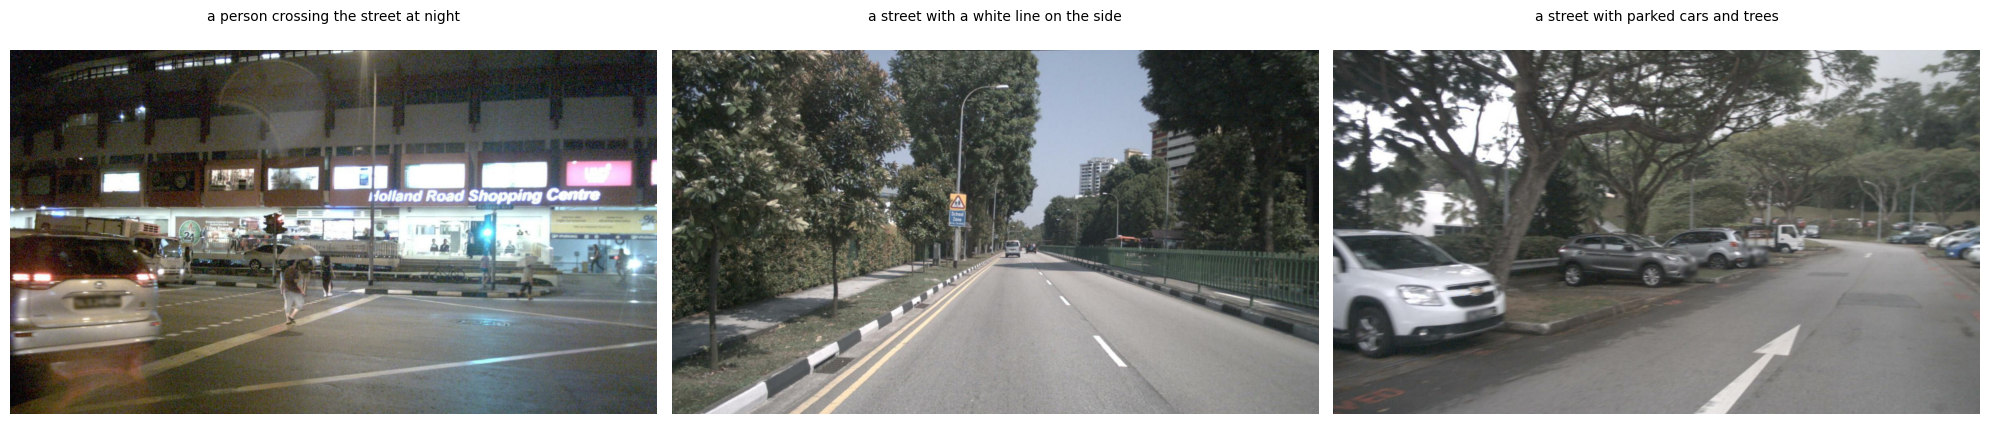

In [15]:
fig = plt.figure(figsize=(20, 15))
num_samples = 3

for i, example in enumerate(dataset["test"]):
  if i >= num_samples:
    break

  image_path = example["image_path"]
  image = Image.open(image_path).convert("RGB")

  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  fig.add_subplot(1, num_samples, i + 1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"{generated_caption}", fontsize=10, pad=10)

plt.tight_layout()
plt.show()

# COCO dataset

In [4]:
coco = fiftyone.zoo.load_zoo_dataset(
  "coco-2017",
  split="validation",
  label_types=["detections"],
  classes=["bicycle", "motorcycle", "bus", "truck", "car", "traffic light", "stop sign"],
  max_samples=80,
)
print(coco.first())

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [5.0m elapsed, 0s remaining, 5.4Mb/s]       


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [5.0m elapsed, 0s remaining, 5.4Mb/s]       


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Downloading 80 images


 100% |████████████████████| 80/80 [9.1s elapsed, 0s remaining, 9.5 images/s]      


INFO:eta.core.utils: 100% |████████████████████| 80/80 [9.1s elapsed, 0s remaining, 9.5 images/s]      


Writing annotations for 80 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 80 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |███████████████████| 80/80 [541.6ms elapsed, 0s remaining, 147.7 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 80/80 [541.6ms elapsed, 0s remaining, 147.7 samples/s]      


Dataset 'coco-2017-validation-80' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-validation-80' created


<Sample: {
    'id': '6758362a8f45f6e5011a7e55',
    'media_type': 'image',
    'filepath': '/root/fiftyone/coco-2017/validation/data/000000000724.jpg',
    'tags': ['validation'],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 375,
        'height': 500,
        'num_channels': None,
    }>,
    'created_at': datetime.datetime(2024, 12, 10, 12, 38, 2, 94000),
    'last_modified_at': datetime.datetime(2024, 12, 10, 12, 38, 2, 94000),
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '6758362a8f45f6e5011a7e51',
                'attributes': {},
                'tags': [],
                'label': 'stop sign',
                'bounding_box': [
                    0.3201866666666667,
                    0.14366,
                    0.35864,
                    0.30616000000000004,
                ],
                'mask': None,
                'confidence': None,
          

In [6]:
import pandas as pd

captions_data = []

for sample in coco:
  image_path = sample.filepath
  labels = [det.label for det in sample.ground_truth.detections]
  unique_labels = list(set(labels))

  if len(unique_labels) > 1:
      caption = f"The image contains {', '.join(unique_labels[:-1])}, and {unique_labels[-1]}."
  elif unique_labels:
      caption = f"The image contains {unique_labels[0]}."
  else:
      caption = "The image contains no detectable driving related objects."

  captions_data.append({"image_path": image_path, "caption": caption})

coco_df = pd.DataFrame(captions_data)
coco_csv_path = '/content/coco_dataset.csv'
coco_df.to_csv(coco_csv_path, index=False)
print(coco_df.head())

                                          image_path  \
0  /root/fiftyone/coco-2017/validation/data/00000...   
1  /root/fiftyone/coco-2017/validation/data/00000...   
2  /root/fiftyone/coco-2017/validation/data/00000...   
3  /root/fiftyone/coco-2017/validation/data/00000...   
4  /root/fiftyone/coco-2017/validation/data/00000...   

                                             caption  
0      The image contains truck, car, and stop sign.  
1                 The image contains truck, and car.  
2                The image contains person, and bus.  
3  The image contains tie, traffic light, person,...  
4  The image contains bicycle, person, scissors, ...  


In [7]:
class COCODataset(Dataset):
  def __init__(self, dataset, processor, max_length=32):
    self.dataset = dataset
    self.processor = processor
    self.max_length = max_length

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = Image.open(item["image_path"]).convert("RGB")
    caption = item["caption"]
    encoding = self.processor(
        images=image,
        text=caption,
        padding="max_length",
        truncation=True,
        max_length=self.max_length,
        return_tensors="pt"
    )

    encoding = {k: v.squeeze(0) for k, v in encoding.items()}
    encoding["ground_truth"] = caption
    return encoding

def coco_collate_fn(batch):
  pixel_values = torch.stack([example["pixel_values"] for example in batch], dim=0)
  ground_truths = [example["ground_truth"] for example in batch]

  return {"pixel_values": pixel_values, "ground_truths": ground_truths}

In [8]:
coco_dataset = load_dataset("csv", data_files=coco_csv_path)

coco_dataset = COCODataset(coco_dataset["train"], processor)
coco_dataloader = DataLoader(coco_dataset, batch_size=8, shuffle=False, collate_fn=coco_collate_fn)

Generating train split: 0 examples [00:00, ? examples/s]

## Evaluation with COCO dataset

In [9]:
def evaluate_coco_model(model, dataloader, processor, device):
  model.eval()
  generated_captions = []
  references = []

  for batch in dataloader:
      pixel_values = batch["pixel_values"].to(device, torch.float16)
      ground_truths = batch["ground_truths"]

      with torch.no_grad():
          generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=25)
          captions = processor.batch_decode(generated_ids, skip_special_tokens=True)

      generated_captions.extend(captions)
      references.extend(ground_truths)

  return generated_captions, references

def evaluate_coco_performance(predictions, references):
  gts = {i: [ref] for i, ref in enumerate(references)}
  res = {i: [pred] for i, pred in enumerate(predictions)}

  cider_scorer = Cider()
  cider_score, _ = cider_scorer.compute_score(gts, res)

  spice_scorer = Spice()
  spice_score, _ = spice_scorer.compute_score(gts, res)

  return cider_score, spice_score

In [12]:
generated_captions, references = evaluate_coco_model(model, coco_dataloader, processor, device)
cider_score, spice_score = evaluate_coco_performance(generated_captions, references)
print(f"COCO Evaluation - CIDEr: {cider_score:.4f}, SPICE: {spice_score:.4f}")

Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
COCO Evaluation - CIDEr: 0.0553, SPICE: 0.1677


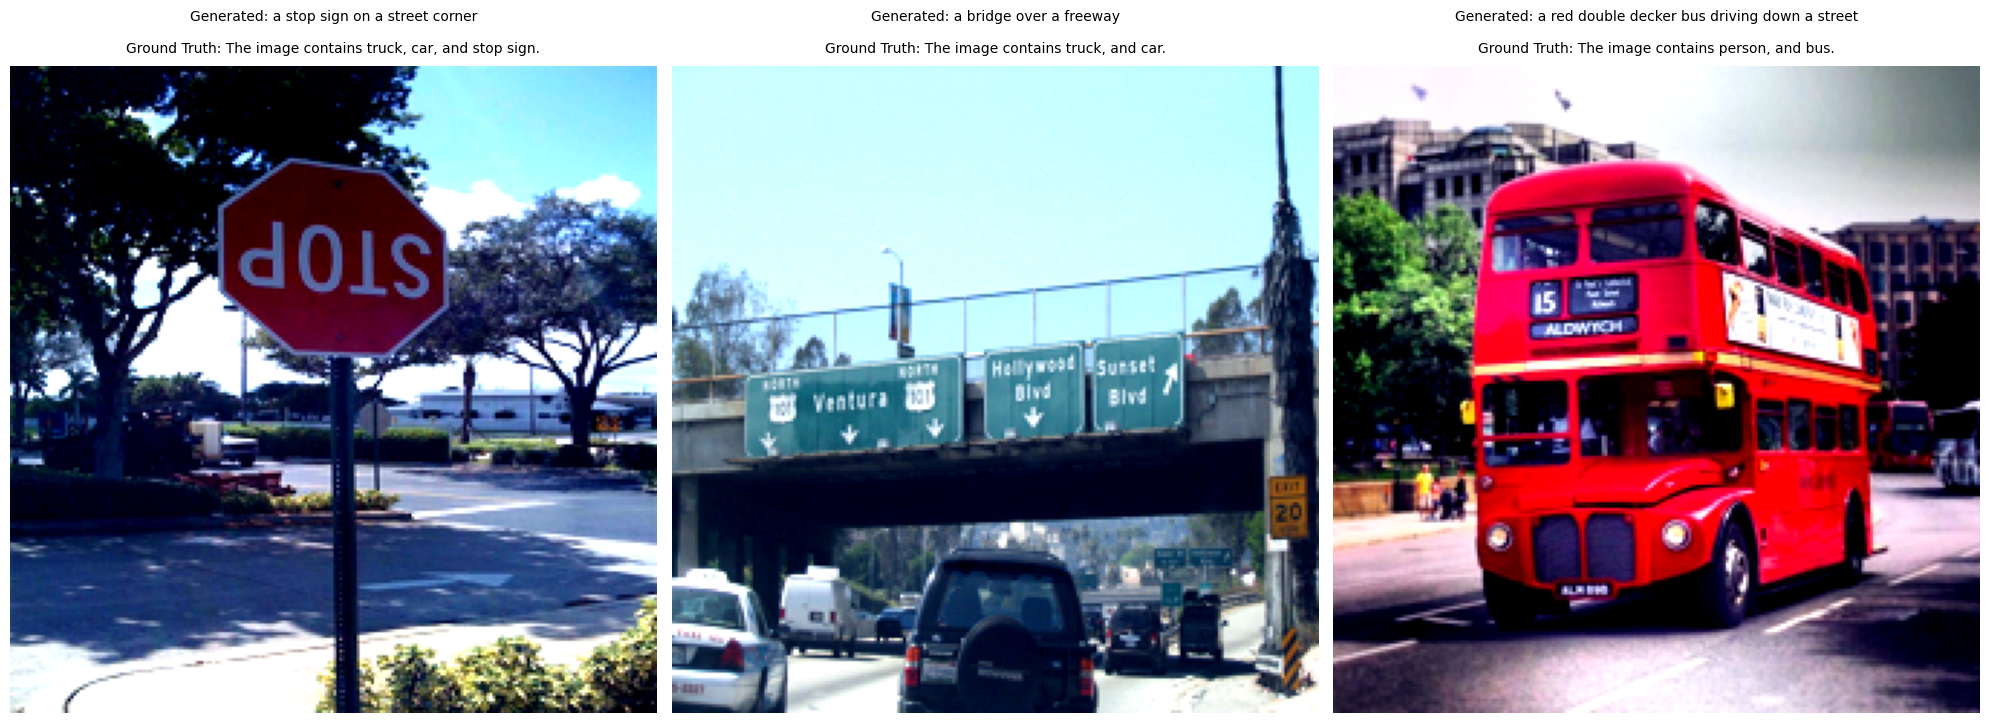

In [13]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

fig = plt.figure(figsize=(20, 15))
num_samples = 3

def pixel_values_to_image(pixel_values):
  pixel_values = pixel_values.squeeze(0).cpu()
  pixel_values = (pixel_values * 0.5 + 0.5).clamp(0, 1)
  return ToPILImage()(pixel_values)

for i, example in enumerate(coco_dataset):
  if i >= num_samples:
      break

  pixel_values = example["pixel_values"]

  ground_truth = example["ground_truth"]

  inputs = {"pixel_values": pixel_values.unsqueeze(0).to(device, torch.float16)}
  generated_ids = model.generate(pixel_values=inputs["pixel_values"], max_new_tokens=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  image = pixel_values_to_image(pixel_values)

  ax = fig.add_subplot(1, num_samples, i + 1)
  ax.imshow(image)
  ax.axis("off")
  ax.set_title(
      f"Generated: {generated_caption}\nGround Truth: {ground_truth}",
      fontsize=10,
      pad=10,
  )

plt.tight_layout()
plt.show()

# Fine-Tuning

In [20]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,750,004,736 || trainable%: 0.1398


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

model.train()

for epoch in range(30):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss
    print("Loss:", loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # torch.save(model.state_dict(), f"model_epoch_{epoch}.pt")

Epoch: 0
Loss: 11.359375
Loss: 11.2265625
Loss: 10.6875
Loss: 10.375
Loss: 9.6484375
Loss: 9.03125
Loss: 8.25
Loss: 7.4765625
Loss: 6.859375
Loss: 6.171875
Loss: 5.28515625
Loss: 4.82421875
Loss: 4.765625
Loss: 4.578125
Loss: 4.234375
Loss: 3.951171875
Loss: 3.93359375
Loss: 3.5078125
Loss: 3.447265625
Loss: 3.15625
Loss: 2.962890625
Loss: 2.9296875
Loss: 2.8203125
Loss: 2.732421875
Loss: 2.623046875
Loss: 2.591796875
Loss: 2.361328125
Loss: 2.255859375
Loss: 2.36328125
Loss: 2.123046875
Loss: 2.150390625
Loss: 1.9931640625
Loss: 2.009765625
Loss: 1.892578125
Loss: 1.9091796875
Loss: 1.7099609375
Loss: 1.78515625
Loss: 1.6943359375
Loss: 1.7734375
Loss: 1.677734375
Loss: 1.60546875
Epoch: 1
Loss: 1.5380859375
Loss: 1.4765625
Loss: 1.4365234375
Loss: 1.3857421875
Loss: 1.37109375
Loss: 1.2763671875
Loss: 1.4775390625
Loss: 1.3447265625
Loss: 1.2939453125
Loss: 1.3251953125
Loss: 1.2529296875
Loss: 1.2314453125
Loss: 1.1474609375
Loss: 1.1435546875
Loss: 1.0205078125
Loss: 1.119140625
Lo

# Evaluation after Fine-Tuning

## Evaluation with nuScenes dataset

In [33]:
trained_cider, trained_spice = evaluate_model(model, test_dataloader, processor, device)
print(f"Trained Model - CIDEr: {trained_cider:.4f}, SPICE: {trained_spice:.4f}")

Trained Model - CIDEr: 9.6197, SPICE: 0.9766


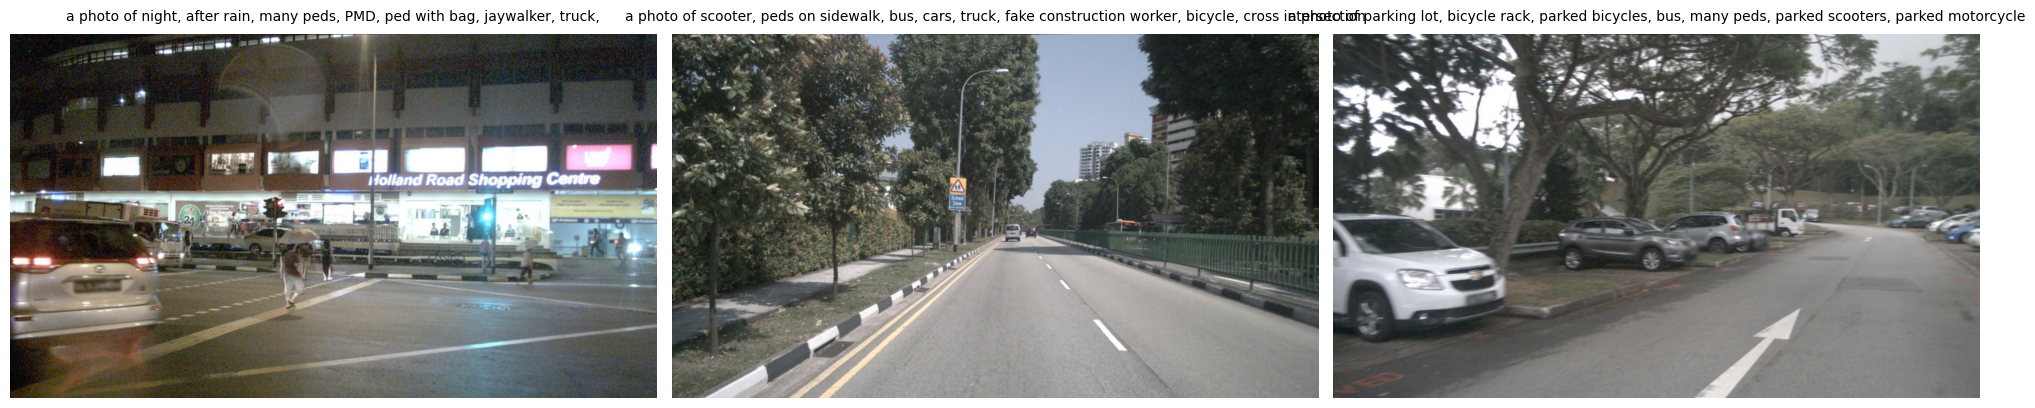

In [34]:
fig = plt.figure(figsize=(20, 15))
num_samples = 3

for i, example in enumerate(dataset["test"]):
  if i >= num_samples:
    break

  image_path = example["image_path"]
  image = Image.open(image_path).convert("RGB")

  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  fig.add_subplot(1, num_samples, i + 1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"{generated_caption}", fontsize=10, pad=10)

plt.tight_layout()
plt.show()

## Evaluation with COCO dataset

In [22]:
generated_captions, references = evaluate_coco_model(model, coco_dataloader, processor, device)
cider_score, spice_score = evaluate_coco_performance(generated_captions, references)
print(f"COCO Evaluation - CIDEr: {cider_score:.4f}, SPICE: {spice_score:.4f}")

COCO Evaluation - CIDEr: 0.0231, SPICE: 0.0356


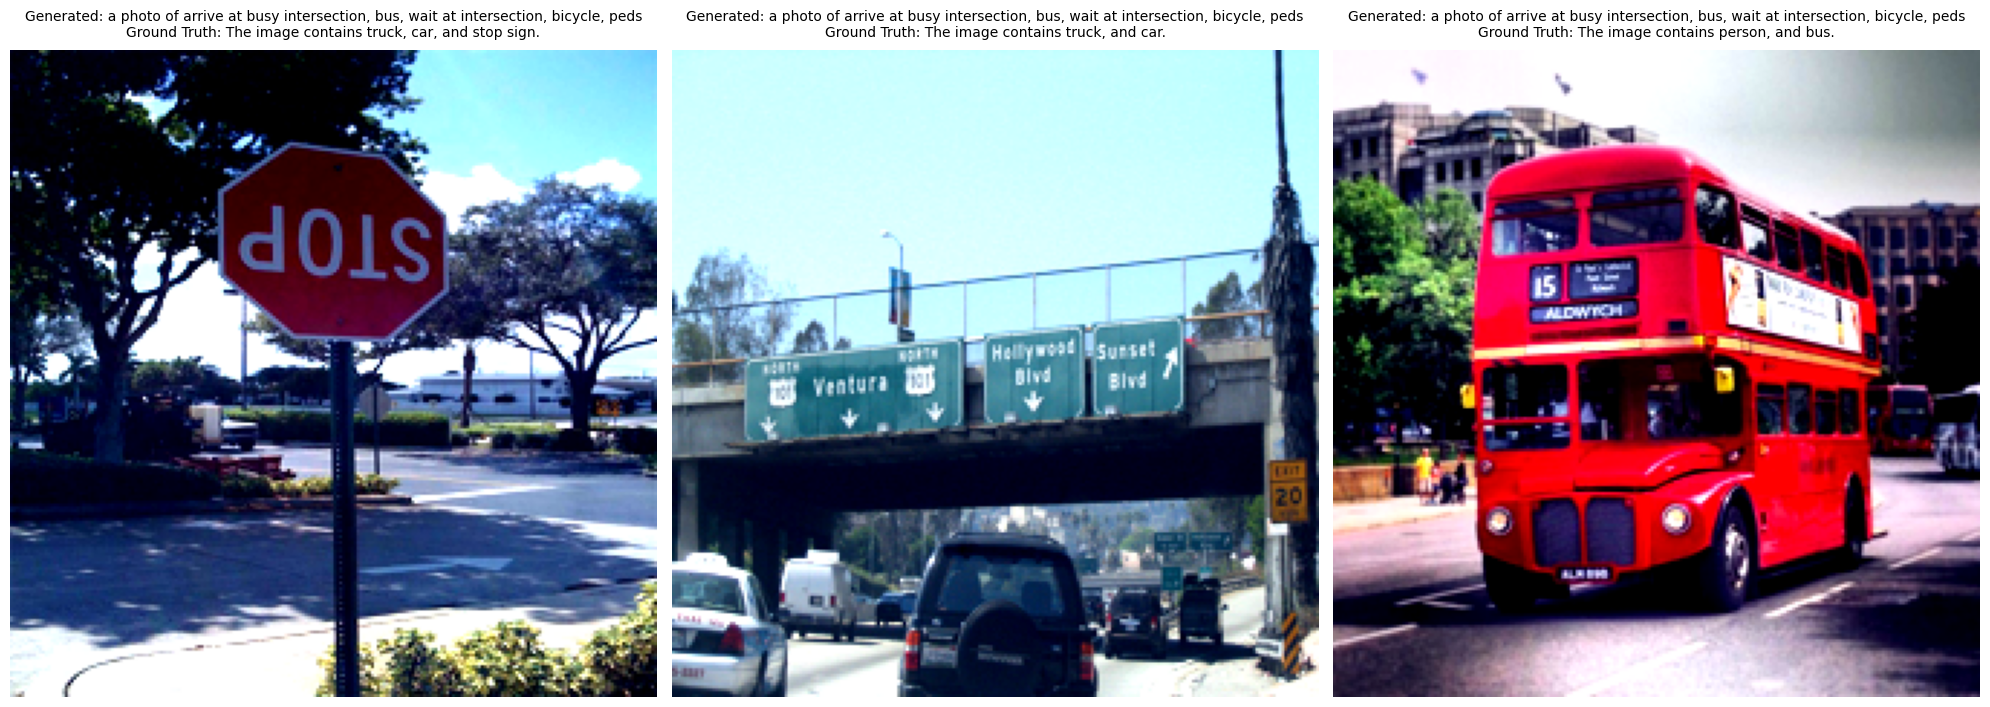

In [23]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

fig = plt.figure(figsize=(20, 15))
num_samples = 3

def pixel_values_to_image(pixel_values):
  pixel_values = pixel_values.squeeze(0).cpu()
  pixel_values = (pixel_values * 0.5 + 0.5).clamp(0, 1)
  return ToPILImage()(pixel_values)

for i, example in enumerate(coco_dataset):
  if i >= num_samples:
      break

  pixel_values = example["pixel_values"]

  ground_truth = example["ground_truth"]

  inputs = {"pixel_values": pixel_values.unsqueeze(0).to(device, torch.float16)}
  generated_ids = model.generate(pixel_values=inputs["pixel_values"], max_new_tokens=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  image = pixel_values_to_image(pixel_values)

  ax = fig.add_subplot(1, num_samples, i + 1)
  ax.imshow(image)
  ax.axis("off")
  ax.set_title(
      f"Generated: {generated_caption}\nGround Truth: {ground_truth}",
      fontsize=10,
      pad=10,
  )

plt.tight_layout()
plt.show()